# Best LSTMs vs M4 data heat map

## Imports

In [1]:
import json
import os

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from collections import defaultdict

## Load data

In [2]:
M4_RESULTS_PATH='../../data/fine_tuned/results/vs_m4.json'

In [3]:
with open(M4_RESULTS_PATH, 'r') as file:
    data = json.load(file)

In [8]:
data

[{'base_model': 'bigscience-bloomz-7b1',
  'results_against_all_llms': [{'arxiv_bloomz': {'test_loss': 2.608117841659708,
     'test_acc': 51.583333333333336,
     'test_f1': 0.485020386456302,
     'test_recall': 0.456,
     'test_precision': 0.5179856115107914,
     'test_brier': 0,
     'test_auc_tuple': 0}},
   {'arxiv_cohere': {'test_loss': 1.424439291558922,
     'test_acc': 71.5,
     'test_f1': 0.7498537156231714,
     'test_recall': 0.8543333333333333,
     'test_precision': 0.6681438998957248,
     'test_brier': 0,
     'test_auc_tuple': 0}},
   {'arxiv_davinci': {'test_loss': 1.6556449495652255,
     'test_acc': 65.96666666666667,
     'test_f1': 0.686039360393604,
     'test_recall': 0.7436666666666667,
     'test_precision': 0.6367009132420092,
     'test_brier': 0,
     'test_auc_tuple': 0}},
   {'arxiv_flant5': {'test_loss': 1.1230566279295129,
     'test_acc': 77.05,
     'test_f1': 0.8079230018133631,
     'test_recall': 0.9653333333333334,
     'test_precision': 0.694

## Plot heat map

In [16]:
def plot_heat_map(data, metric_min, metric_max, metric='test_acc'):
    heatmap_data = []

    for item in data:
        base_model = item['base_model']
        results = {}
        results['base_model'] = base_model
        
        for dataset_result in item['results_against_all_llms']:
            for model_name, model_data in dataset_result.items():
                results[model_name] = model_data[metric]
        
        heatmap_data.append(results)
    
    # Create DataFrame
    df = pd.DataFrame(heatmap_data)
    df.set_index('base_model', inplace=True)
    df = df.sort_index(axis=1)
    
    plt.figure(figsize=(16,5))
    ax = sb.heatmap(df,
                    annot=True,
                    annot_kws={"size": 22},
                    cmap='viridis_r',
                    linewidths=0,
                    cbar_kws={'label': f'{metric}'},
                    vmin=metric_min,
                    vmax=metric_max )
    ax.set(xlabel="", ylabel="")
    ax.set_aspect('equal')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, rotation=0)

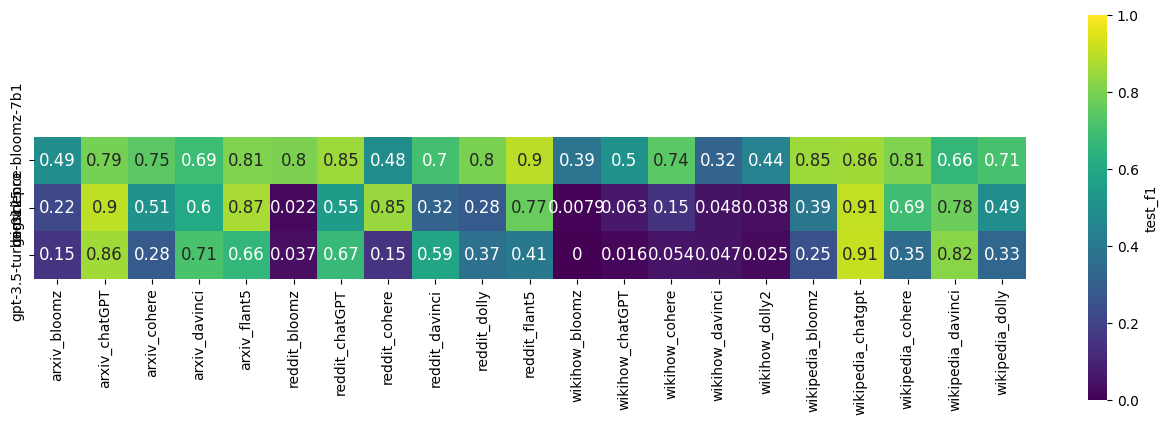

In [10]:
plot_heat_map(data, metric_min=0, metric_max=1, metric='test_f1')

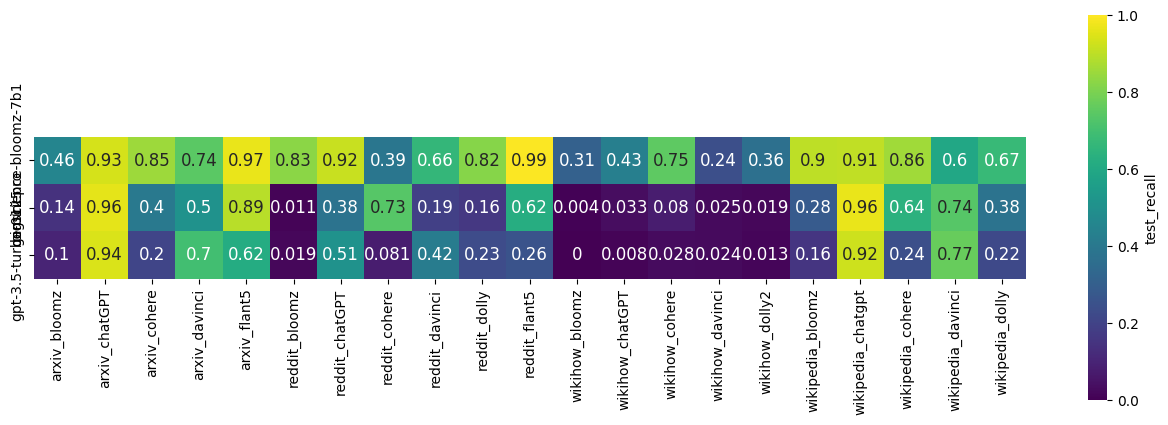

In [12]:
plot_heat_map(data, metric_min=0, metric_max=1, metric='test_recall')

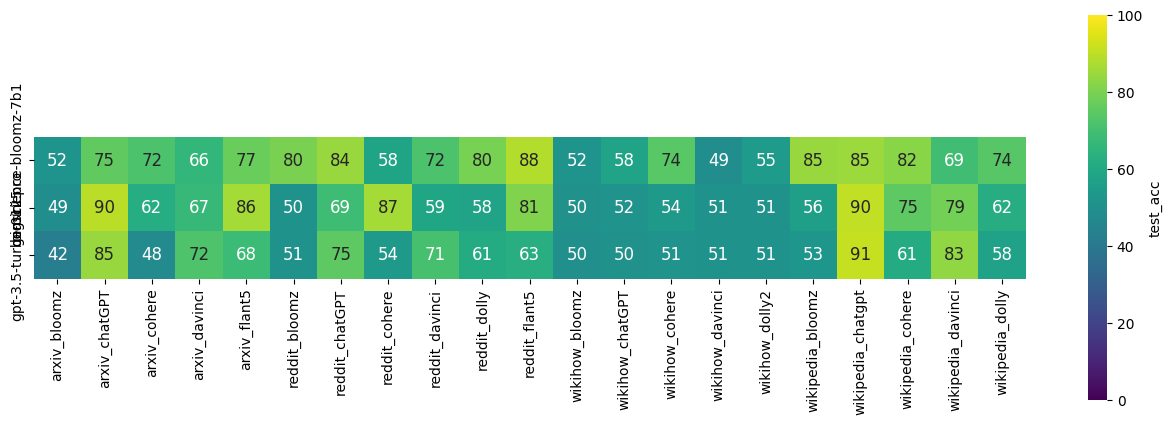

In [13]:
plot_heat_map(data, metric_min=0, metric_max=100, metric='test_acc')

## Average the metrics by LLM

In [5]:
metrics_to_average = [
    "test_loss",
    "test_acc",
    "test_f1",
    "test_recall",
    "test_precision",
    "test_brier",
]

In [19]:
llm_average_data = []

In [18]:
llms_to_show = ['bloomz', 'chatgpt', 'flant5']

In [20]:
for item in data:
    base_model = item['base_model']
    results = {}
    results['base_model'] = base_model
    results['results_against_all_llms'] = []
    
    # Initialize dictionaries to accumulate the metrics and count the occurrences
    metrics_sum = defaultdict(lambda: defaultdict(float))
    metrics_count = defaultdict(lambda: defaultdict(int))

    # Iterate over the results to accumulate metrics
    for result in item['results_against_all_llms']:
        for key, metrics in result.items():
            _, llm_name = key.rsplit('_', 1)
            llm_name = llm_name.lower()
            if 'dolly' in llm_name:
                llm_name = 'dolly'

            if llm_name not in llms_to_show:
                continue

            for metric in metrics_to_average:
                metrics_sum[llm_name][metric] += metrics[metric]
                metrics_count[llm_name][metric] += 1

    # Calculate the average for each metric based on the domain
    averages = defaultdict(dict)
    for llm_name, metrics in metrics_sum.items():
        for metric, total in metrics.items():
            averages[llm_name][metric] = total / metrics_count[llm_name][metric]
        
    for average_results in averages:
        results['results_against_all_llms'].append({average_results: averages[average_results]})

    llm_average_data.append(results)

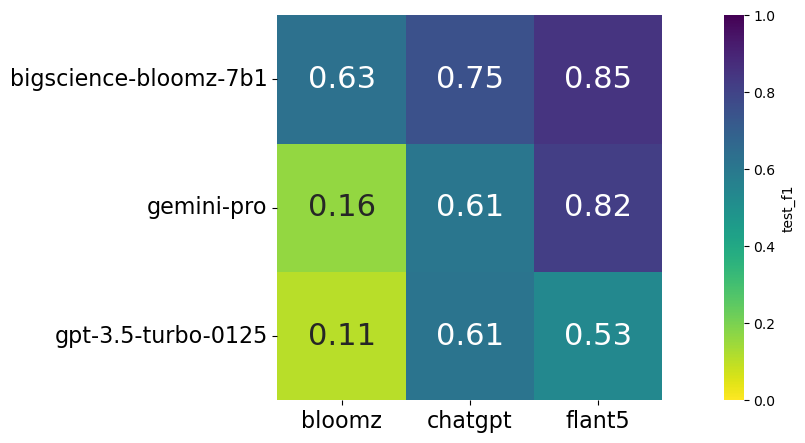

In [21]:
plot_heat_map(llm_average_data, metric_min=0, metric_max=1, metric='test_f1')

## Average the metrics by domain

In [22]:
metrics_to_average = [
    "test_loss",
    "test_acc",
    "test_f1",
    "test_recall",
    "test_precision",
    "test_brier",
]

In [23]:
domain_average_data = []

In [24]:
for item in data:
    base_model = item['base_model']
    results = {}
    results['base_model'] = base_model
    results['results_against_all_llms'] = []
    
    # Initialize dictionaries to accumulate the metrics and count the occurrences
    metrics_sum = defaultdict(lambda: defaultdict(float))
    metrics_count = defaultdict(lambda: defaultdict(int))

    # Iterate over the results to accumulate metrics
    for result in item['results_against_all_llms']:
        for key, metrics in result.items():
            domain, _ = key.rsplit('_', 1)
            for metric in metrics_to_average:
                metrics_sum[domain][metric] += metrics[metric]
                metrics_count[domain][metric] += 1

    # Calculate the average for each metric based on the domain
    averages = defaultdict(dict)
    for domain, metrics in metrics_sum.items():
        for metric, total in metrics.items():
            averages[domain][metric] = total / metrics_count[domain][metric]
        
    for average_results in averages:
        results['results_against_all_llms'].append({average_results: averages[average_results]})

    domain_average_data.append(results)

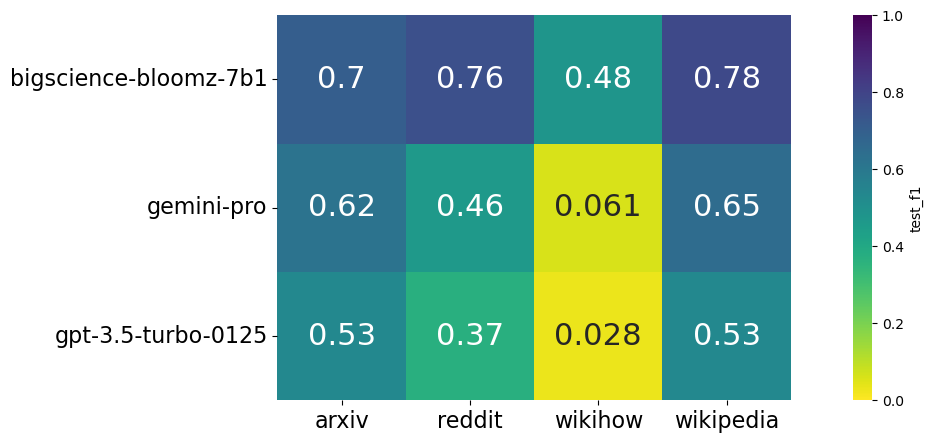

In [25]:
plot_heat_map(domain_average_data, metric_min=0, metric_max=1, metric='test_f1')